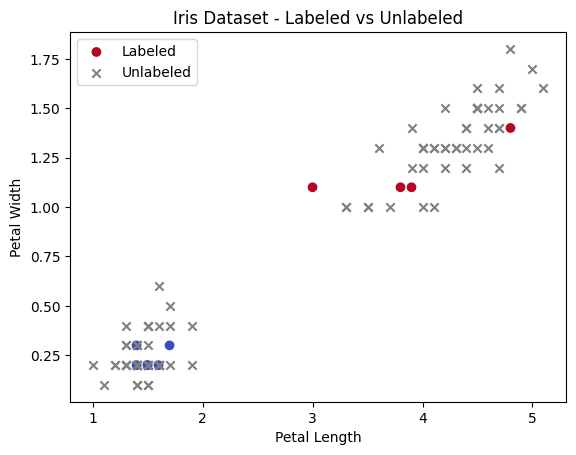

In [1]:
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt

# --- IRIS verisini yükle ---
iris = load_iris()
X_all = iris.data
y_all = iris.target

# Sadece 2 sınıfı seç (Setosa: 0, Versicolor: 1)
mask = y_all < 2
X = X_all[mask][:, [2, 3]]  # 2D: petal length & petal width
y_true = y_all[mask]
y_true[y_true == 0] = -1  # sınıflar: -1 ve +1

# Parametreler
N = len(X)
l = 10  # etiketli örnek sayısı
u = N - l

# --- Etiketli ve etiketsiz ayrımı ---
labeled_indices = np.random.choice(N, l, replace=False)
unlabeled_indices = np.setdiff1d(np.arange(N), labeled_indices)

# Etiket vektörü
y_labeled = np.full(N, np.nan)
y_labeled[labeled_indices] = y_true[labeled_indices]

# --- Görselleştir ---
plt.scatter(X[labeled_indices, 0], X[labeled_indices, 1], c=y_labeled[labeled_indices], cmap='coolwarm', marker='o', label="Labeled")
plt.scatter(X[unlabeled_indices, 0], X[unlabeled_indices, 1], color='gray', marker='x', label="Unlabeled")
plt.title("Iris Dataset - Labeled vs Unlabeled")
plt.xlabel("Petal Length")
plt.ylabel("Petal Width")
plt.legend()
plt.show()


In [4]:
def rbf_similarity(x1, x2, sigma=1.0):
    dist_sq = np.sum((x1 - x2) ** 2)
    return np.exp(-dist_sq / (sigma ** 2))

W = np.zeros((len(labeled_indices), len(unlabeled_indices)))
W_tilde = np.zeros((len(unlabeled_indices), len(unlabeled_indices)))

sigma = 1.0

# w_ij: labeled ↔ unlabeled
for i, li in enumerate(labeled_indices):
    for j, uj in enumerate(unlabeled_indices):
        W[i, j] = rbf_similarity(X[li], X[uj], sigma=sigma)

# w̃_ij: unlabeled ↔ unlabeled
for i, ui in enumerate(unlabeled_indices):
    for j, uj in enumerate(unlabeled_indices):
        if i != j:
            W_tilde[i, j] = rbf_similarity(X[ui], X[uj], sigma=sigma)


In [5]:
# Başlangıç: etiketsizler için rastgele tahmin
y_unlabeled = np.random.randn(len(unlabeled_indices))

# Sabit: etiketli y'ler
y_l = y_true[labeled_indices]

# Öğrenme parametreleri
lr = 0.01
max_iter = 1000

for epoch in range(max_iter):
    grad = np.zeros_like(y_unlabeled)

    # Etiketli–etiketsiz kısmın gradyanı
    for j, uj in enumerate(unlabeled_indices):
        for i, li in enumerate(labeled_indices):
            grad[j] += 2 * W[i, j] * (y_unlabeled[j] - y_l[i])

    # Etiketsiz–etiketsiz kısmın gradyanı
    for j in range(len(unlabeled_indices)):
        for i in range(len(unlabeled_indices)):
            if i != j:
                grad[j] += 2 * W_tilde[i, j] * (y_unlabeled[j] - y_unlabeled[i])

    y_unlabeled -= lr * grad

# Tahminler
y_pred = np.sign(y_unlabeled)


Accuracy on unlabeled data: 1.00


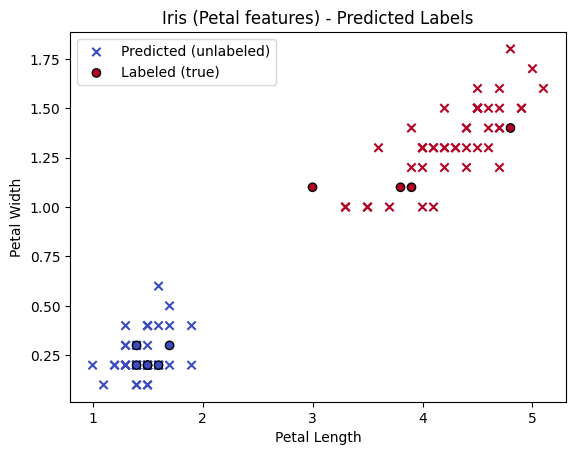

In [6]:
from sklearn.metrics import accuracy_score

# Doğruluk
acc = accuracy_score(y_true[unlabeled_indices], y_pred)
print(f"Accuracy on unlabeled data: {acc:.2f}")

# Çizim
plt.scatter(X[unlabeled_indices, 0], X[unlabeled_indices, 1], c=y_pred, cmap='coolwarm', marker='x', label="Predicted (unlabeled)")
plt.scatter(X[labeled_indices, 0], X[labeled_indices, 1], c=y_true[labeled_indices], cmap='coolwarm', marker='o', edgecolor='k', label="Labeled (true)")
plt.title("Iris (Petal features) - Predicted Labels")
plt.xlabel("Petal Length")
plt.ylabel("Petal Width")
plt.legend()
plt.show()
